Code to accompany the paper
"Model-independent pricing with insider information: a Skorokhod embedding approach"
by Beatrice Acciaio, Alexander M. G. Cox and Martin Huesmann.


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (12, 6)

alpha is:  0.125


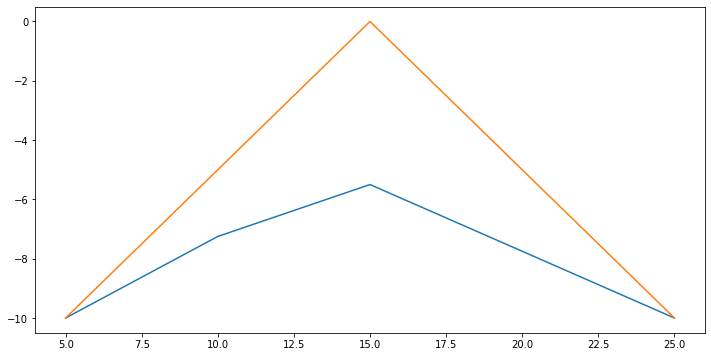

In [3]:
# Try to solve the following simple example:
#   Atoms at S0-L, S0-L/2, S0, S0+L
#   Before hitting S0+L/2, process stops at or above S0-L
#   After hitting S0+L/2, must stop at or before hitting S0-L/2
#   Need to determine how much to initally stop at S0-L/2, S0
#     before hitting S0+L/2.

# Set up the space
mx = 10 #Min/Max space range.
N = 100 # Number of space steps
M = 200000 # Number of time steps.
S0 = 15 # Initial value of asset

x = np.linspace(-mx,mx,2*N+1)+S0 # Space grid

dx = x[1]-x[0] # Space step

dt = dx**2/4. # Time step. Set to ensure convergence/stability of algorithm.
T_mx = dt*M # Max time

alpha = dt/(dx**2)/2.
print("alpha is: ",alpha) # Should be less than 0.5 [CHECK] to ensure convergence/stability of Euler solve

t = np.linspace(0,T_mx,M+1) # time grid


NL = int(N/2.0) # Index of atom at -L/2
NL2 = N+NL # Index of upper barrier
p1 = 0.1 # Probability to embed at -L/2
p2 = 0.4 # Probability to embed at 0
# Compute probabilities at -L, L:
p0 = (p1*(x[2*N]-x[NL])+p2*(x[2*N]-x[N])-x[2*N]+x[N])/(x[0]-x[2*N])
p3 = 1-p0-p1-p2

# x-values at important points.
x0 = x[0]
x1 = x[NL]
x2 = x[N]
x3 = x[2*N]

# Array of atom locations, probabilities
at = np.array([x[0],x[NL],x[N],x[2*N]])
prob = np.array([p0,p1,p2,p3])

# Potential function corresponding to measure to be embedded.
def pot(at,prob,x): 
    return -prob@np.abs(np.ones((4,2*N+1))*x-(np.ones((2*N+1,4))*at).T)

# Potential at x associated to embedding measure on a, b with initial atom at x0.
def pot2(a,b,x0,x):
    return np.maximum(np.minimum((x-a)*2*(b-x0)/(b-a),(b-x)*2*(1-(b-x0)/(b-a))),np.zeros(np.shape(x)))

# Potential function to embed.
umu = pot(at,prob,x)

plt.plot(x,umu,x,-np.abs(x-S0));

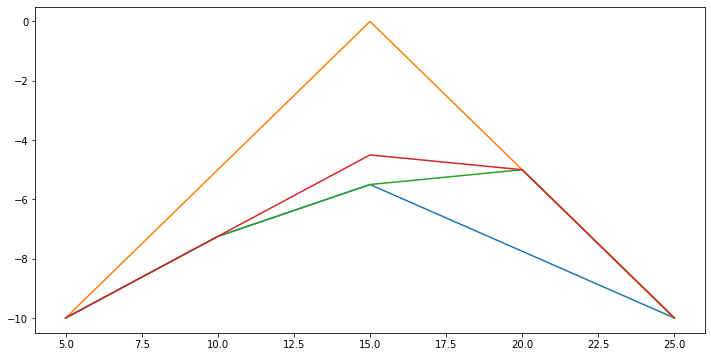

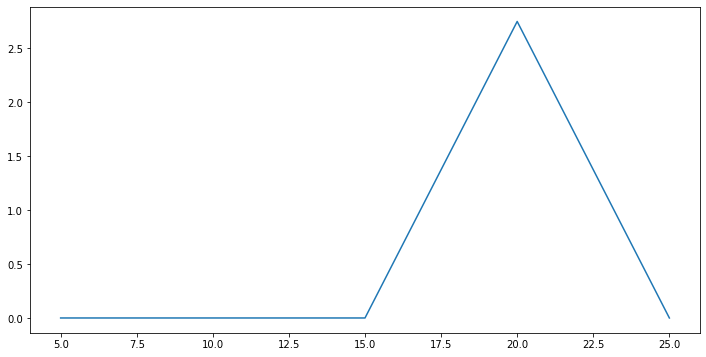

In [4]:
# Compute the potential of the measure to be embedded before hitting S0+L/2.
# Indexed by a parameter delta. Delta=0 corresponds to stopping as much as possible at S0-L/2
# Delta = 1 corresponds to stopping as much as possible at S0


NL2 = 150

def umu_interm(delta,NL2):
    lam = (-np.abs(x[NL2]-S0)-umu[:NL2])/(x[NL2]-x[:NL2])
    N_crit = np.argmin((-np.abs(x[NL2]-S0)-umu[:NL2])/(x[NL2]-x[:NL2]))


    umu0 = np.zeros(2*N+1)
    umu0[:N_crit] = umu[:N_crit]
    umu0[N_crit:NL2] = umu[N_crit]+lam[N_crit]*(x[N_crit:NL2]-x[N_crit])
    umu0[NL2:] = -np.abs(x[NL2:]-S0)
    #plt.plot(x,umu,x,-np.abs(x),x,umu[N_crit]+lam[N_crit]*(x-x[N_crit]));

    y1 = umu[NL]+(x[N]-x[NL])*(umu[NL]-umu[NL-1])/(x[NL]-x[NL-1])
    y2 = y1

    pr1 = ((umu[NL]-umu[NL-1])/(x[NL]-x[NL-1])
           - (-(x[NL2]-S0)-y1)/(x[NL2]-x[N]))/2.
    pr2 = ((umu[N]-umu[N-1])/(x[N]-x[N-1])
           -(umu[N+1]-umu[N])/(x[N+1]-x[N]))/2.

    if pr1 < pr2:
        # Put no mass at x1 in stage 1
        umu1 = np.minimum(x[0]-S0+(x-x[0])*(y1-(x[0]-S0))/(x[N]-x[0]),
                    np.minimum(-(x-S0),
                          y1 + (x-x[N])*(-x[NL2]+S0-y1)/(x[NL2]-x[N])))
    else:
        # Put mass at x1 in stage 1, no mass at x2 in stage 2.
        # Solve (-x[NL2]+S0-y2)/(x[NL2]-x[N]) - (y2-umu[NL])/(x[N]-x[NL]) 
        #         = (umu[N+1]-umu[N])/(x[N+1]-x[N])-(umu[N]-umu[N-1])/(x[N]-x[N-1])
        y2 = (((-x[NL2]+S0)/(x[NL2]-x[N])+ umu[NL]/(x[N]-x[NL])
               - (umu[N+1]-umu[N])/(x[N+1]-x[N])+(umu[N]-umu[N-1])/(x[N]-x[N-1]))
              /(1./(x[NL2]-x[N])+1./(x[N]-x[NL])))
        umu1 = np.minimum(-np.abs(x-S0),
                    np.minimum(umu[NL]+(x-x[NL])*(y2-umu[NL])/(x[N]-x[NL]),
                          np.minimum(y2+(-x[NL2]+S0-y2)*(x-x[N])/(x[NL2]-x[N]),
                               x[0]-S0+(x-x[0])*(umu[1]-umu[0])/(x[1]-x[0]))))
    return (1-delta)*umu0+delta*umu1


        
plt.plot(x,umu,x,-np.abs(x-S0),x,umu_interm(0.,NL2),x,umu_interm(1.,NL2));
plt.figure()
plt.plot(x,umu_interm(0.,NL2)-umu)

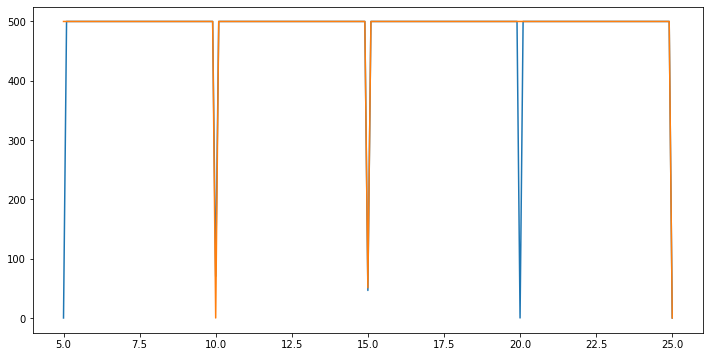

In [5]:
# Solve the embedding problem.
# Compute for a fixed delta \in (0,1), representing the possible slope at x[NL2-]:
# delta = 0 corresponds to: stop as little mass as possible before NL2
# delta = 1 corresponds to: stop as much mass as possible before NL2

delta = 0.5
umu_target = umu_interm(delta,NL2)

u = np.zeros((2,M+1,2*N+1)) # Potential of stopped/restarted measures
u_tot = np.zeros((M+1,2*N+1)) # Total potential
#w = np.zeros((2,2*N+1,2*N+1))
#u_rem = np.zeros((2,M+1,2*N+1))

bar = np.zeros((2,M+1,2*N+1)) # Barriers.

u[0,0,:] = -np.abs(x-S0)

# Discretize the Laplacian
A = alpha*np.diag(np.ones(2*N),1) + alpha*np.diag(np.ones(2*N),-1)+(1-2.*alpha)*np.eye(2*N+1)
A[0,1] = 0.0
A[0,0] = 1.0
A[2*N,2*N-1] = 0.0
A[2*N,2*N] = 1.0

A2 = np.copy(A)
A2[NL,:] = np.zeros(2*N+1)
A2[NL,NL] = 1.0
atoms_idx = [0,NL,N,NL2,2*N]

for i in range(M):
    # bar[0,i,:] = 1*(u[0,i,:]<=umu0)
    bar[0,i,atoms_idx] = 1*(u[0,i,atoms_idx]<=umu_target[atoms_idx])
    bar[0,i,NL2] = 1

    #temp = u[0,i,N] -umu[N] - ((1+(-(x[NL2]-S0)-u[0,i,NL2-1])/(x[NL2]-x[NL2-1]))/2.*
    #                pot2(x[NL],x[2*N],x[NL2],x[N]) - 
    #                u[1,i,N])
    
    #bar[0,i,N] = max((bar[0,i-1,N] if i>0 else 0),
    #                       (temp <= 0))
    
    
    u[0,i+1,:] = (1-bar[0,i,:])*(A@u[0,i,:])+bar[0,i,:]*u[0,i,:]
    if i > 0:
        u[1,i,:] = u[1,i,:] + pot2(x[NL],x[2*N],x[NL2],x)*(
            (u[0,i-1,NL2-1]-u[0,i-1,NL2])-(u[0,i,NL2-1]-u[0,i,NL2]))/dx/2.
    else:
        u[1,i,:] = u[1,i,:] + pot2(x[NL],x[2*N],x[NL2],x)*(
            1-(u[0,i,NL2-1]-u[0,i,NL2])/dx)/2.

    
        
    # bar[1,i,atoms_idx] = 1*(umu0[atoms_idx]-((1-(u[0,i,N+NL-1]-u[0,i,N+NL])/dx)/2.*
    #                      pot2(x[NL],x[2*N],x[NL+N],x[atoms_idx]))+u[1,i,atoms_idx] <= umu[atoms_idx])
    #bar[1,i,:] = 1*(umu0-((1-(u[0,i,N+NL-1]-u[0,i,N+NL])/dx)/2.*
    #                      pot2(x[NL],x[2*N],x[NL+N],x))+u[1,i,:] <= umu)

    bar[1,i,NL] = 1
    bar[1,i,2*N] = 1
    bar[1,i,N] = 1*(umu_target[N]-((1-(u[0,i,NL2-1]-u[0,i,NL2])/dx)/2.*
                        pot2(x[NL],x[2*N],x[NL2],x[N]))+u[1,i,N] <= umu[N])
    
    u[1,i+1,:] = (1-bar[1,i,:])*(A2@u[1,i,:])+bar[1,i,:]*u[1,i,:]
    u_tot[i+1,:] = u[0,i+1,:]+u[1,i+1,:] - (1-(u[0,i+1,NL2-1]-u[0,i+1,NL2])/dx)/2.*(pot2(x[NL],x[2*N],x[NL2],x))

bar_t = T_mx-dt*np.sum(bar,1)

plt.plot(x,bar_t[0,:],x,bar_t[1,:])

In [6]:
# Define a function to simulate from the hitting distribution.

def simulate(r,nMax):
    B = S0+np.cumsum(np.sqrt(dt)*np.random.normal(0,1,M+1))
    B2 = np.minimum(np.maximum(np.array((B-S0)/dx+N,dtype='int32'),np.zeros(M+1)),np.ones(M+1)*(2*N))
    B2 = B2.astype('int32',copy=False)
    #plt.plot(t,B,r[0,:],x)
    
    #print(B2[0])
    #print(r[0,B2[0]])
    
    n0 = np.argmax((r[0,B2]<t))
    t0 = t[n0]
    if n0 == 0:
        n0 = M
        t0 = t[M]

    if (B2[n0]>=nMax):
        n1 = np.argmax((r[1,B2[n0:]]<t[n0:]))+n0
        if (n1==n0) and (r[1,B2[n0]] >= t[n0]):
            n1 = M
            t1 = t[M]
        else:
            t1 = t[n1]
    else:
        n1 = n0
        t1 = t0
    
    #plt.plot(t,B,t[0:(n0+1)],B[0:(n0+1)],t[n0:(n1+1)],B[n0:(n1+1)],r[0,:],x,r[1,:],x);

    
    
    return (t0,x[B2[n0]],t1,x[B2[n1]])

simulate(bar_t,NL2)

(38.324999999999726, 20.0, 76.02999999999946, 25.0)

Average Score:  7.064499605162603
95% Confidence Interval: [ 6.978357040384388 ,  7.150642169940818 ]
Theoretical Score:  7.100402282184623


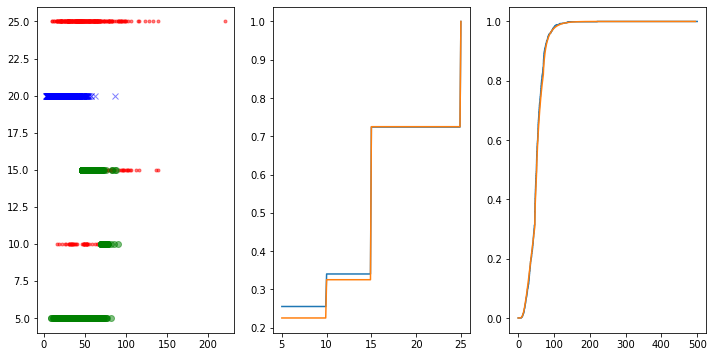

In [7]:
# Check the barrier by simulation.

nn = 1000 # Number of simulations
tt = np.zeros((2,nn))
xx = np.zeros((2,nn))
zz = np.zeros(nn)

for i in range(nn):
    (tt[0,i],xx[0,i],tt[1,i],xx[1,i]) = simulate(bar_t,NL2)
    zz[i] =  (tt[0,i] == tt[1,i])
    
zz = zz.astype('bool',copy=True)

plt.subplot(1,3,1)
plt.plot(tt[0,~zz],xx[0,~zz],'bx',tt[1,~zz],xx[1,~zz],'r.',tt[0,zz],xx[0,zz],'go',alpha=0.5);

df = np.zeros(2*N+1)

for i in range(2*N+1):
    df[i] = np.sum((xx[1,:]<=x[i]))

#print(df[2*N])
df = df/nn

df_true = p0*(x>=x0) + p1*(x>=x1) + p2*(x>=x2) + p3*(x>=x3)
#df_true = p0*(x>x0) + p1*(x>x1) + p2*(x>x2) + p3*(x>x3)

plt.subplot(1,3,2)
plt.plot(x,df,x,df_true);

df_t = np.zeros(M+1)

for i in range(M+1):
    df_t[i] = np.sum((tt[1,:]<=t[i]))
    
df_t = df_t/nn

# Compute the stopping law from the barrier.
j = 100
M2 = round(M/(j+1))

temp = np.zeros(M2)

t2 = np.zeros(M2)

for i in range(M2):
    t2[i] = t[j*i]
    
    u2 = np.append([x[0]-S0-dx],np.append(u[0,j*i,:],[-x[2*N]+S0-dx]))
    
    temp[i] = np.sum(-np.diff(np.diff(u2/dx)/dx)*bar[0,j*i,:]*(x<x[NL2]))*dx/2.
    
    u2 = np.append([0.],np.append(u[1,j*i,:],[0.]))
    
    temp[i] += (1-(u[0,j*i,NL2-1]-u[0,j*i,NL2])/dx)/2.
    
    temp[i] += np.sum(np.diff(np.diff(u2/dx)/dx)*(1-bar[1,j*i,:]))*dx/2.

plt.subplot(1,3,3)

plt.plot(t,df_t,t2,temp);

Test_Function = lambda t: np.sqrt(t)
mn = np.mean(Test_Function(tt[1,:]))
sd = np.std(Test_Function(tt[1,:]))
print("Average Score: ",np.mean(Test_Function(tt[1,:])))
print("95% Confidence Interval: [",mn-1.96*sd/np.sqrt(nn),", ",mn+1.96*sd/np.sqrt(nn),"]")
print("Theoretical Score: ",np.dot(np.diff(temp),0.5*(Test_Function(t2[1:])+Test_Function(t2[:-1]))))

In [8]:
def findBarrier(umu,nMax, delta, tf = lambda t: np.sqrt(t)):
    delta = max(0.,min(delta,1.0))
    NL2 = nMax
    lam = (-np.abs(x[NL2]-S0)-umu[:NL2])/(x[NL2]-x[:NL2])
    N_crit = np.argmin((-np.abs(x[NL2]-S0)-umu[:NL2])/(x[NL2]-x[:NL2]))
    
    umu_target = umu_interm(delta,NL2)
        
    u = np.zeros((2,M+1,2*N+1)) # Potential of stopped/restarted measures
    u_tot = np.zeros((M+1,2*N+1)) # Total potential

    bar = np.zeros((2,M+1,2*N+1)) # Barriers.

    u[0,0,:] = -np.abs(x-S0)

    # Discretize the Laplacian
    A = alpha*np.diag(np.ones(2*N),1) + alpha*np.diag(np.ones(2*N),-1)+(1-2.*alpha)*np.eye(2*N+1)
    A[0,1] = 0.0
    A[0,0] = 1.0
    A[2*N,2*N-1] = 0.0
    A[2*N,2*N] = 1.0

    A2 = np.copy(A)
    A2[NL,:] = np.zeros(2*N+1)
    A2[NL,NL] = 1.0
    atoms_idx = [0,NL,N,NL2,2*N]

    for i in range(M):
        # bar[0,i,:] = 1*(u[0,i,:]<=umu0)
        bar[0,i,atoms_idx] = 1*(u[0,i,atoms_idx]<=umu_target[atoms_idx])
        bar[0,i,NL2] = 1

        u[0,i+1,:] = (1-bar[0,i,:])*(A@u[0,i,:])+bar[0,i,:]*u[0,i,:]
        if i > 0:
            u[1,i,:] = u[1,i,:] + pot2(x[NL],x[2*N],x[NL2],x)*(
                (u[0,i-1,NL2-1]-u[0,i-1,NL2])-(u[0,i,NL2-1]-u[0,i,NL2]))/dx/2.
        else:
            u[1,i,:] = u[1,i,:] + pot2(x[NL],x[2*N],x[NL2],x)*(
                1-(u[0,i,NL2-1]-u[0,i,NL2])/dx)/2.

        bar[1,i,NL] = 1
        bar[1,i,2*N] = 1
        bar[1,i,N] = 1*(umu_target[N]-((1-(u[0,i,NL2-1]-u[0,i,NL2])/dx)/2.*
                            pot2(x[NL],x[2*N],x[NL2],x[N]))+u[1,i,N] <= umu[N])

        u[1,i+1,:] = (1-bar[1,i,:])*(A2@u[1,i,:])+bar[1,i,:]*u[1,i,:]
        u_tot[i+1,:] = u[0,i+1,:]+u[1,i+1,:] - (1-(u[0,i+1,NL2-1]-u[0,i+1,NL2])/dx)/2.*(pot2(x[NL],x[2*N],x[NL2],x))

    bar_t = T_mx-dt*np.sum(bar,1)
    
    # Compute the stopping law from the barrier.
    j = 100
    M2 = round(M/(j+1))

    temp = np.zeros(M2)

    t2 = np.zeros(M2)

    for i in range(M2):
        t2[i] = t[j*i]

        u2 = np.append([x[0]-S0-dx],np.append(u[0,j*i,:],[-x[2*N]+S0-dx]))

        temp[i] = np.sum(-np.diff(np.diff(u2/dx)/dx)*bar[0,j*i,:]*(x<x[NL2]))*dx/2.

        u2 = np.append([0.],np.append(u[1,j*i,:],[0.]))

        temp[i] += (1-(u[0,j*i,NL2-1]-u[0,j*i,NL2])/dx)/2.

        temp[i] += np.sum(np.diff(np.diff(u2/dx)/dx)*(1-bar[1,j*i,:]))*dx/2.

    score = np.dot(np.diff(temp),0.5*(tf(t2[1:])+tf(t2[:-1])))
    
    return (bar_t,t2,temp,score)

(r,t2,dist,score) = findBarrier(umu,NL2,0.5)
print(score)

7.100402282184623


In [9]:
# Find the critical value for the max, below this -> arbitrage
# umu[NL] + (y-x[NL])*(umu[NL]-umu[NL-1])/(x[NL]-x[NL-1]) = -(y-S0)
y = (umu[NL] - S0 - (x[NL])*(umu[NL]-umu[NL-1])/(x[NL]-x[NL-1]))/(-1-(umu[NL]-umu[NL-1])/(x[NL]-x[NL-1]))
N_crit = np.sum((x<y))
print(y, N_crit, x[N_crit])


NL2_vec = np.linspace(N_crit,200,13,dtype=int)
delta_vec = np.linspace(0.,1.,10)

17.90322580645162 130 18.0


[7.05221004 7.07810044 7.09230731 7.099602   7.10135406 7.09835029
 7.09086305 7.07870818 7.0617576  7.03850685]
4


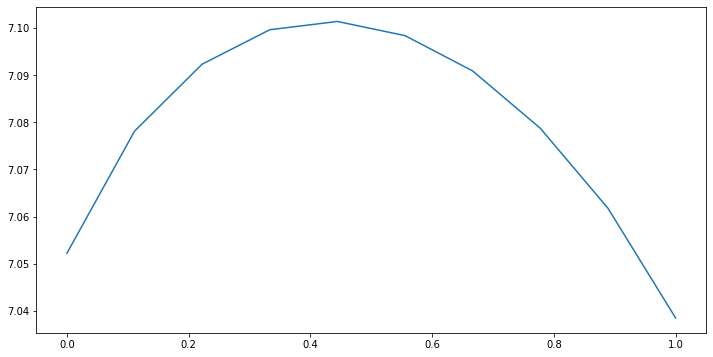

In [10]:
def findOptimalDelta(umu, NL2, n, tf = lambda t: np.sqrt(t), verbose=False):
    val = np.zeros(n)
    delta_vec = np.linspace(0.,1.,n)
    sol = []
    for j in range(n):
        sol.append(findBarrier(umu,NL2,delta_vec[j], tf = tf))
        val[j] = sol[j][3]
    j0 = np.argmax(val)
    if verbose:
        print(val)
        plt.plot(delta_vec,val)
        print(j0)
    return sol[j0]

sol0 = findOptimalDelta(umu, NL2, 10, verbose=True)

[6.98648839 6.9894576  6.99229374 6.99491317 6.99738034 6.99978788
 7.00208937 7.00428119 7.00635649 7.00833258]
9
[6.99418494 7.01057744 7.02426706 7.03595468 7.04602419 7.05426356
 7.0608892  7.06580224 7.0688599  7.06983263]
9
[6.95437548 7.00139654 7.03242693 7.05517213 7.07147899 7.08231157
 7.08815176 7.08912332 7.08489886 7.07510378]
7
[7.03154639 7.06133986 7.08012647 7.09166875 7.09741426 7.09840037
 7.09449012 7.08618388 7.07292174 7.05378338]
5
[7.06603612 7.0893567  7.09974896 7.10344773 7.10183974 7.09546631
 7.084891   7.06908161 7.04848457 7.02119355]
3
[7.08752693 7.10227037 7.10626288 7.1039447  7.0965402  7.08447024
 7.06756771 7.04560523 7.01735682 6.98040588]
2
[7.09780111 7.10695466 7.10743866 7.10317982 7.09526794 7.08378852
 7.06867528 7.04976714 7.02637598 6.99575003]
2
[7.10224805 7.10853809 7.1078057  7.1032308  7.09583198 7.08597239
 7.07374065 7.05832306 7.03991022 7.01616562]
1
[7.10589828 7.10926112 7.10747066 7.10341272 7.0974347  7.08952289
 7.08001783 7

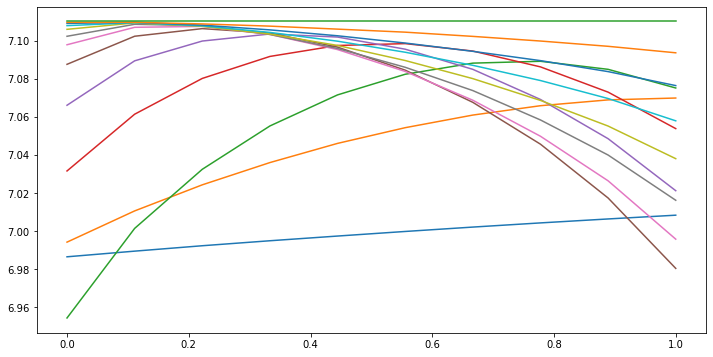

In [11]:
sol = []
score_vec = np.zeros(len(NL2_vec))
for j in range(len(NL2_vec)):
    sol.append(findOptimalDelta(umu,NL2_vec[j],10,verbose=True))
    score_vec[j] = sol[j][3]

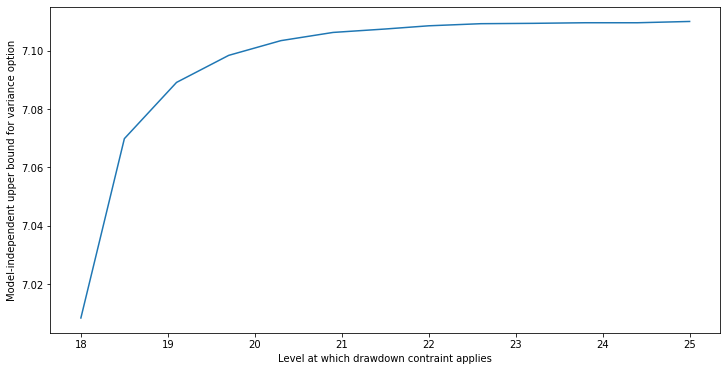

In [12]:
plt.plot(x[NL2_vec],score_vec)
plt.xlabel("Level at which drawdown contraint applies")
plt.ylabel("Model-independent upper bound for variance option")
#plt.title("Model-independent price of Variance option as a function of information");
plt.savefig("Price.pdf")

Average Score:  7.004219202469829
95% Confidence Interval: [ 6.891241550634646 ,  7.117196854305012 ]
Theoretical Score:  7.008332578260397


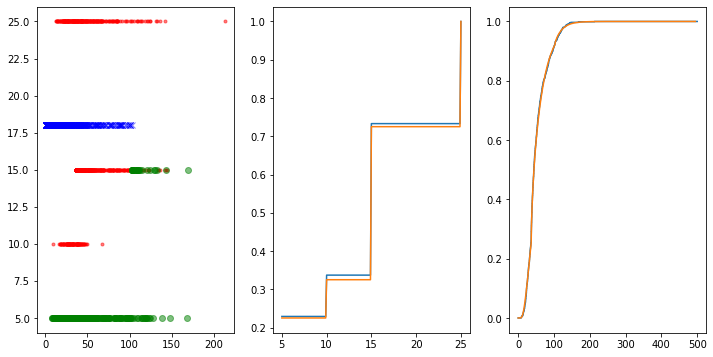

In [13]:
def simTestBarrier(nMax, bar_t, t2, law_comp, actual_score,  nn=1000, tf = lambda t: np.sqrt(t)):
    # Check the barrier by simulation.

    # nn = 1000 # Number of simulations
    tt = np.zeros((2,nn))
    xx = np.zeros((2,nn))
    zz = np.zeros(nn)

    for i in range(nn):
        (tt[0,i],xx[0,i],tt[1,i],xx[1,i]) = simulate(bar_t,nMax)
        zz[i] =  (tt[0,i] == tt[1,i])

    zz = zz.astype('bool',copy=True)

    plt.subplot(1,3,1)
    plt.plot(tt[0,~zz],xx[0,~zz],'bx',tt[1,~zz],xx[1,~zz],'r.',tt[0,zz],xx[0,zz],'go',alpha=0.5);

    df = np.zeros(2*N+1)

    for i in range(2*N+1):
        df[i] = np.sum((xx[1,:]<=x[i]))

    #print(df[2*N])
    df = df/nn

    df_true = p0*(x>=x0) + p1*(x>=x1) + p2*(x>=x2) + p3*(x>=x3)
    #df_true = p0*(x>x0) + p1*(x>x1) + p2*(x>x2) + p3*(x>x3)

    plt.subplot(1,3,2)
    plt.plot(x,df,x,df_true);

    df_t = np.zeros(M+1)

    for i in range(M+1):
        df_t[i] = np.sum((tt[1,:]<=t[i]))

    df_t = df_t/nn

    plt.subplot(1,3,3)

    plt.plot(t,df_t,t2,law_comp);

    mn = np.mean(tf(tt[1,:]))
    sd = np.std(tf(tt[1,:]))
    print("Average Score: ",np.mean(tf(tt[1,:])))
    print("95% Confidence Interval: [",mn-1.96*sd/np.sqrt(nn),", ",mn+1.96*sd/np.sqrt(nn),"]")
    print("Theoretical Score: ",actual_score)
    
simTestBarrier(score_vec[0], *sol[0])

Average Score:  7.078213824587465
95% Confidence Interval: [ 6.959927880555164 ,  7.196499768619765 ]
Theoretical Score:  7.008332578260397
Average Score:  7.025151068302209
95% Confidence Interval: [ 6.931895791093513 ,  7.1184063455109055 ]
Theoretical Score:  7.069832626654186
Average Score:  7.03422160991348
95% Confidence Interval: [ 6.939439571647617 ,  7.129003648179343 ]
Theoretical Score:  7.089123322397338
Average Score:  7.101882256664785
95% Confidence Interval: [ 7.0079021796412855 ,  7.195862333688285 ]
Theoretical Score:  7.098400365585858
Average Score:  7.093291256750459
95% Confidence Interval: [ 7.005332904135381 ,  7.181249609365537 ]
Theoretical Score:  7.1034477266533305
Average Score:  7.158550168044237
95% Confidence Interval: [ 7.073518475982363 ,  7.2435818601061115 ]
Theoretical Score:  7.1062628758934885
Average Score:  7.26112395239429
95% Confidence Interval: [ 7.168609327028868 ,  7.353638577759712 ]
Theoretical Score:  7.107438655960337
Average Score:  7

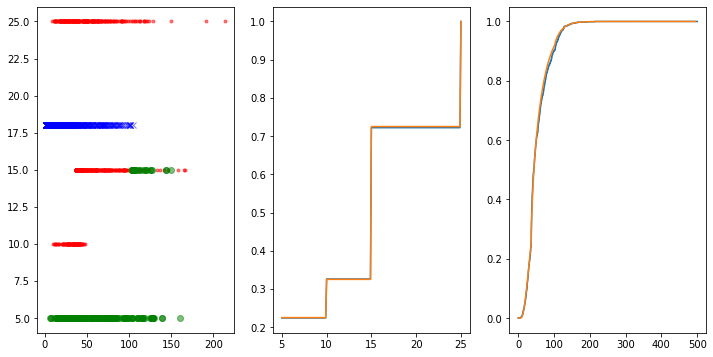

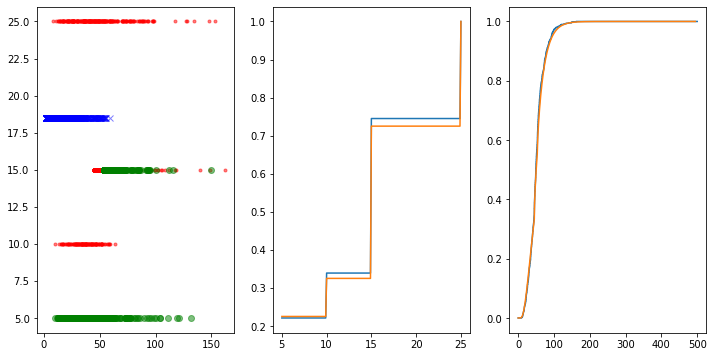

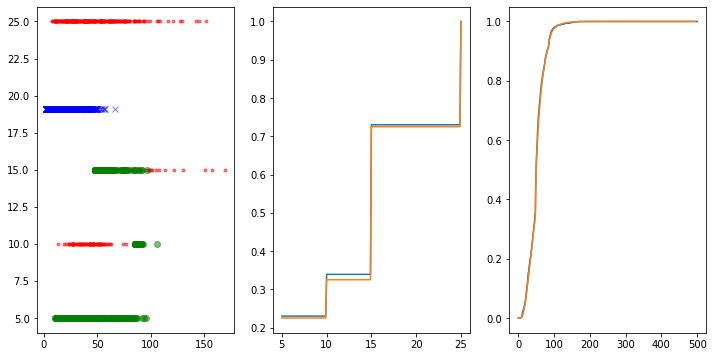

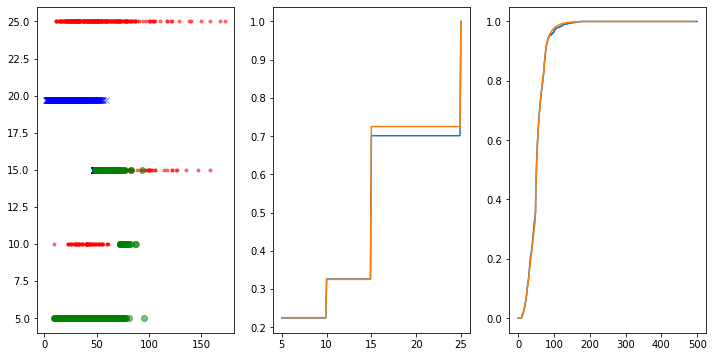

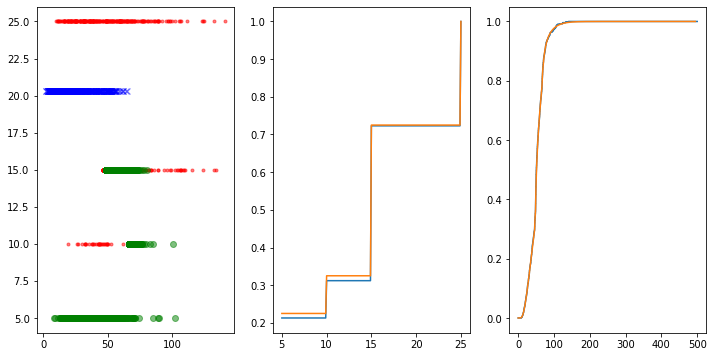

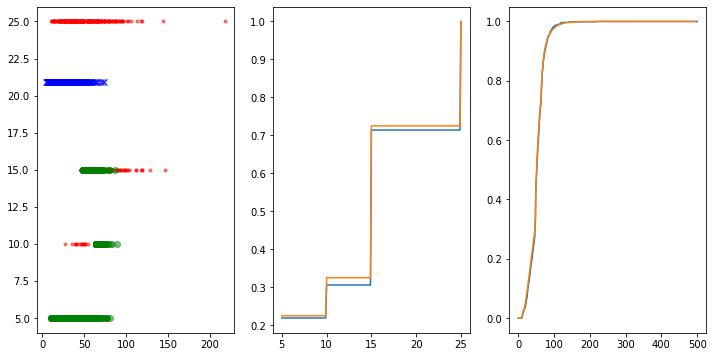

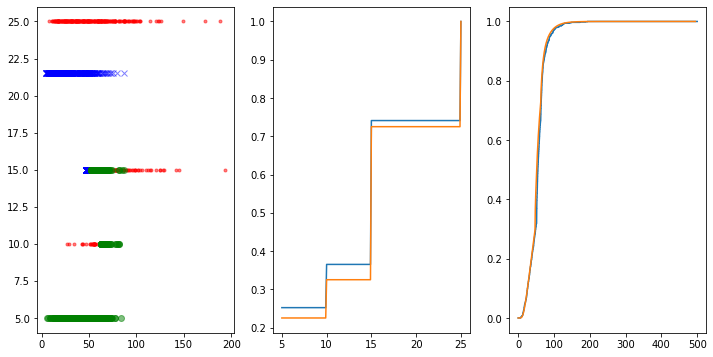

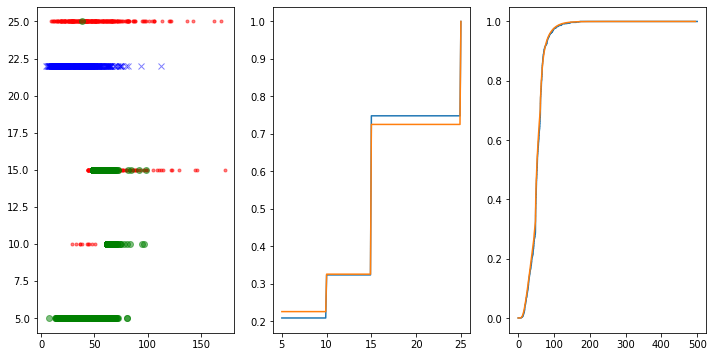

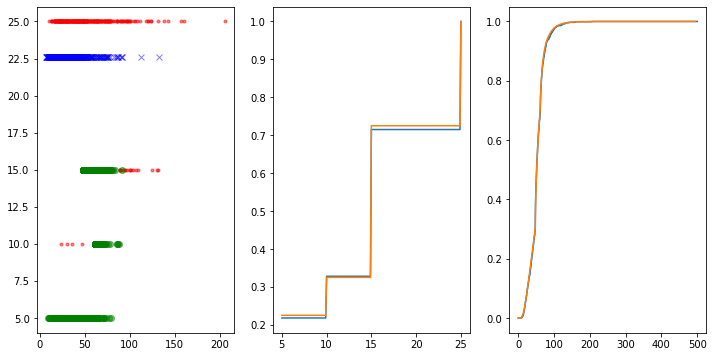

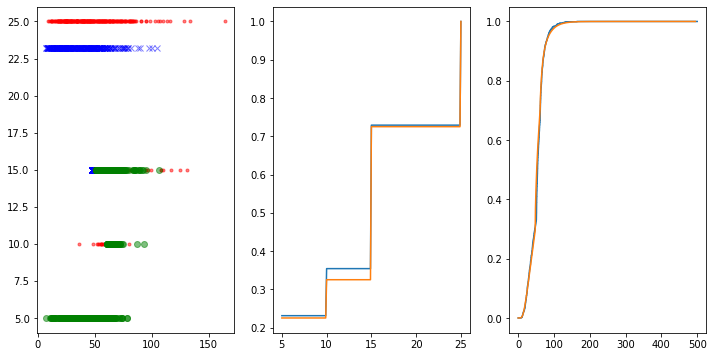

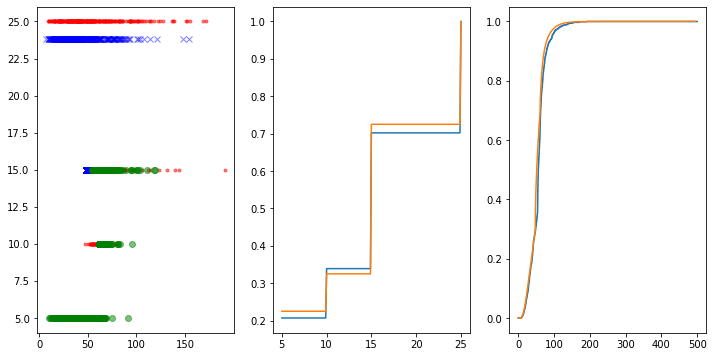

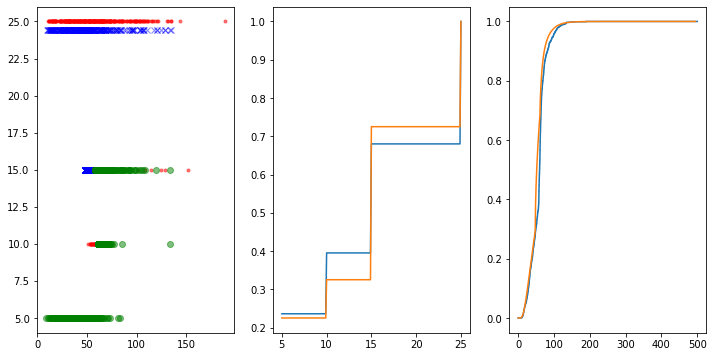

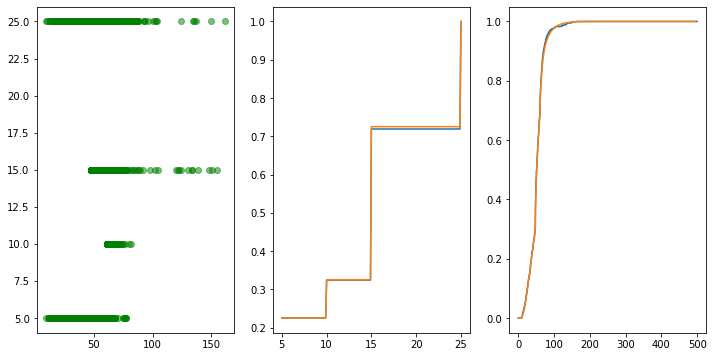

<Figure size 864x432 with 0 Axes>

In [14]:
for i in range(len(sol)):
    simTestBarrier(score_vec[i],*sol[i])
    plt.figure()

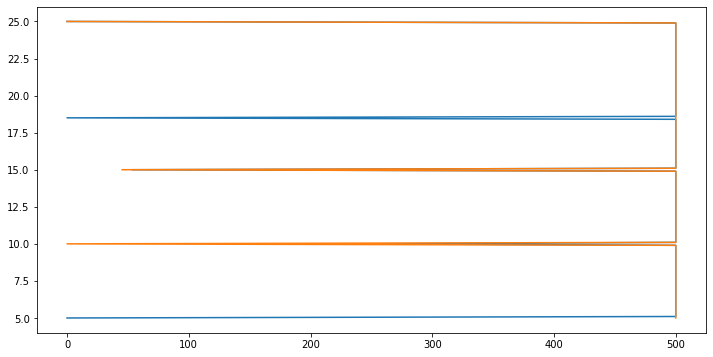

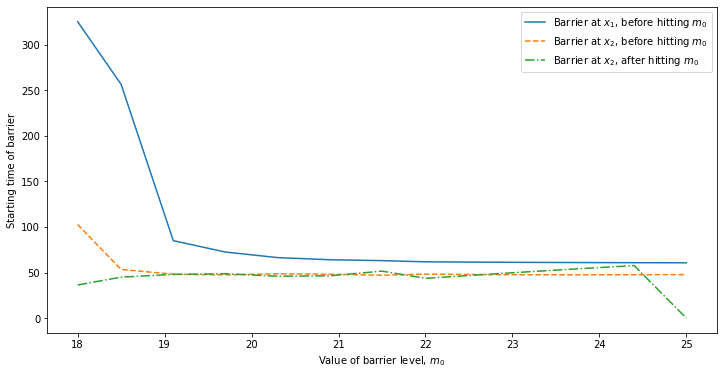

In [29]:
plt.plot(sol[1][0][0],x, sol[1][0][1],x)
z = np.zeros((len(sol),3))

for i in range(len(sol)):
    z[i,0] = sol[i][0][0][NL]
    z[i,1] = sol[i][0][0][N]
    z[i,2] = sol[i][0][1][N]

lab = ["Barrier at $x_1$, before hitting $m_0$", 
       "Barrier at $x_2$, before hitting $m_0$", 
       "Barrier at $x_2$, after hitting $m_0$"]

mrk = ["solid","dashed","dashdot"]

plt.figure()
for i in range(3):
    plt.plot(x[NL2_vec][z[:,i]<T_mx],z[:,i][z[:,i]<T_mx],label = lab[i],linestyle=mrk[i])
plt.xlabel("Value of barrier level, $m_0$")
plt.ylabel("Starting time of barrier")
plt.legend()
plt.savefig("barrier.pdf")

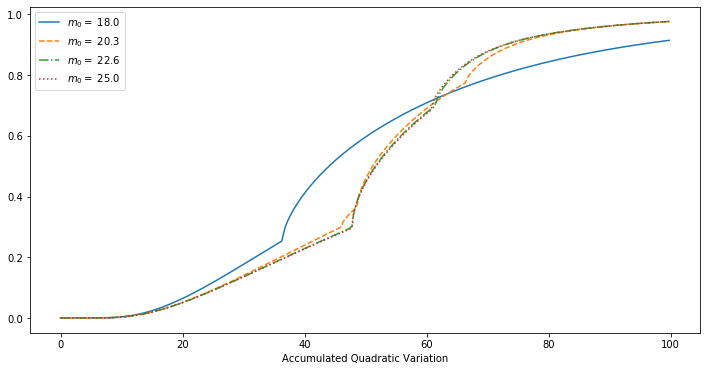

In [32]:
idx = np.linspace(0,len(sol)-1,num=4,dtype="int")

mrk = ["solid","dashed","dashdot","dotted"]
j = 0

for i in idx:
    plt.plot(sol[i][1][:400],sol[i][2][:400],label="$m_0 =$ "+f'{x[NL2_vec[i]]}',
            linestyle=mrk[j])
    j += 1
    plt.xlabel("Accumulated Quadratic Variation")
    #plt.title("Cumulative Distribution of Quadratic Variation for Different Constraints")
    plt.legend()
plt.savefig("CDF.pdf")